In [35]:
# importing required libraries 
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model, Input 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os 
from google_drive_downloader import GoogleDriveDownloader as gdd 
import shutil

# setting random seeds 
np.random.seed(0)
tf.random.set_seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

### For training using TPU

In [36]:
# DISABLE TPU due to some concern with data loading when TPU is enabled 
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Post downloading and extracting the downloaded zip files, following folders will be created . However, these folders are reorganized to a more consistent folder structure 
1. images_without_poachers : contains train, val, test 'images without poachers'
2. split_dataset : contains train, val 'images with poachers'
3. merged_datasets : contains test 'images with poachers'
Folder names are same as in the zipped file. (However, it may be good to use descriptive names in future revisions of the dataset)

### After folder reorganization 
dataset_dat
- train 
  - poachers
  - no_poachers
- val 
  - poachers 
  - no_poachers
- test 
  - poachers 
  - no_poachers 


In [4]:
# downloading project zip file containing 'images without poachers' 
file_id = '1r1u4oB_e4QSeLHVRGKgPWonw6uorxUrk'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/images_without_poachers.zip', unzip=True)


Unzipping...Done.


In [5]:
# downloading project zip files (training and validation images) containing 'images with poachers'
file_id = '1-3Gaaeq_BzCga9dVzIlK9cV-Zj1uy6-i'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/dataset.zip', unzip=True) # this is actually the training and val dataset . zip filename used is same as in the shared google drive


Unzipping...Done.


In [6]:
# downloading project zip files (testing images) containing 'images with poachers'
file_id = '1zTCX81mrwULoziabsOcHMjntuQFFQDD0'
gdd.download_file_from_google_drive(file_id=file_id, dest_path = '/content/test_dataset.zip', unzip=True)  # this is actually the testing dataset. zip filename used is same as in the shared google drive


Unzipping...Done.


In [7]:
# defining various original folderpaths
orig_folderpath_train_poachers    = '/content/split_dataset/images/train/'
orig_folderpath_train_nopoachers  = '/content/images_without_poachers/train/'

orig_folderpath_val_poachers      = '/content/split_dataset/images/val/'
orig_folderpath_val_nopoachers    = '/content/images_without_poachers/val/'

orig_folderpath_test_poachers     = '/content/merged_datasets/test_dataset/images/'
orig_folderpath_test_nopoachers   = '/content/images_without_poachers/test/'

# printing stats on count of images 
print(len(os.listdir(orig_folderpath_train_poachers)), 'trainset poacher images' )
print(len(os.listdir(orig_folderpath_train_nopoachers)), 'trainset without poacher images')
print(len(os.listdir(orig_folderpath_val_poachers)), 'valset poacher images' )
print(len(os.listdir(orig_folderpath_val_nopoachers)), 'valset without poacher images')
print(len(os.listdir(orig_folderpath_test_poachers)), 'testset poacher images' )
print(len(os.listdir(orig_folderpath_test_nopoachers)), 'testset without poacher images')

13111 trainset poacher images
10841 trainset without poacher images
3278 valset poacher images
2711 valset without poacher images
1900 testset poacher images
940 testset without poacher images


In [8]:
# rearranging to a simpler and consistent directory organization 
dst_base_dir = '/content/dataset_dst/'

dst_folderpath_train_poachers    = os.path.join(dst_base_dir , 'train/poachers/')
dst_folderpath_train_nopoachers  = os.path.join(dst_base_dir , 'train/no_poachers/')

dst_folderpath_val_poachers    = os.path.join(dst_base_dir , 'val/poachers/')
dst_folderpath_val_nopoachers  = os.path.join(dst_base_dir , 'val/no_poachers/')

dst_folderpath_test_poachers    = os.path.join(dst_base_dir , 'test/poachers/')
dst_folderpath_test_nopoachers  = os.path.join(dst_base_dir , 'test/no_poachers/')

orig_dst_folderpaths = [  
                         ( orig_folderpath_train_poachers, dst_folderpath_train_poachers ) ,
                         ( orig_folderpath_train_nopoachers, dst_folderpath_train_nopoachers ) ,
                         ( orig_folderpath_val_poachers, dst_folderpath_val_poachers ) ,
                         ( orig_folderpath_val_nopoachers, dst_folderpath_val_nopoachers ) ,
                         ( orig_folderpath_test_poachers, dst_folderpath_test_poachers ) ,
                         ( orig_folderpath_test_nopoachers, dst_folderpath_test_nopoachers ) ,
                       ]

In [9]:
# moving from orig to dst folders 
for orig, dst in orig_dst_folderpaths  :
  if os.path.exists(orig) :
    shutil.move(orig, dst)


In [10]:
# removing older folders 
!rm -r '/content/split_dataset/'
!rm -r '/content/merged_datasets/'
!rm -r '/content/images_without_poachers/'


In [11]:
# verifying total number of files in dst_folderpaths (with previously printed counts before moving folders)
print(len(os.listdir(dst_folderpath_train_poachers)), 'trainset poacher images' )
print(len(os.listdir(dst_folderpath_train_nopoachers)), 'trainset without poacher images')
print(len(os.listdir(dst_folderpath_val_poachers)), 'valset poacher images' )
print(len(os.listdir(dst_folderpath_val_nopoachers)), 'valset without poacher images')
print(len(os.listdir(dst_folderpath_test_poachers)), 'testset poacher images' )
print(len(os.listdir(dst_folderpath_test_nopoachers)), 'testset without poacher images')

13111 trainset poacher images
10841 trainset without poacher images
3278 valset poacher images
2711 valset without poacher images
1900 testset poacher images
940 testset without poacher images


### Defining train, val and test set generators 

In [37]:
image_size = (224, 224)
batch_size = 64
dst_folderpath_train = '/content/dataset_dst/train/'
dst_folderpath_val   = '/content/dataset_dst/val/'
dst_folderpath_test  = '/content/dataset_dst/test/'

print('train_ds')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_train,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'rgb'
)

print('val_ds')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_val,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'rgb'
)

print('test_ds')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dst_folderpath_test,
    image_size=image_size,
    batch_size=batch_size,
    color_mode = 'rgb'
)

# buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

train_ds
Found 23952 files belonging to 2 classes.
val_ds
Found 5989 files belonging to 2 classes.
test_ds
Found 2840 files belonging to 2 classes.


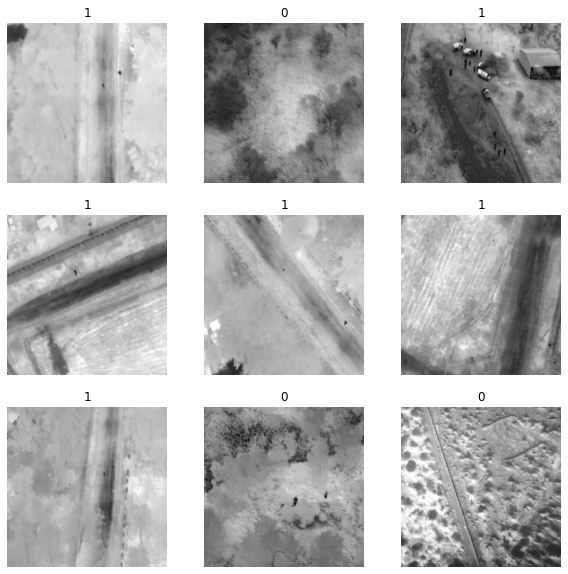

In [39]:
# visualizing the data 
# train 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

# as we can see in the plots, images with poachers are labelled as 1, images without poachers are labelled as 0

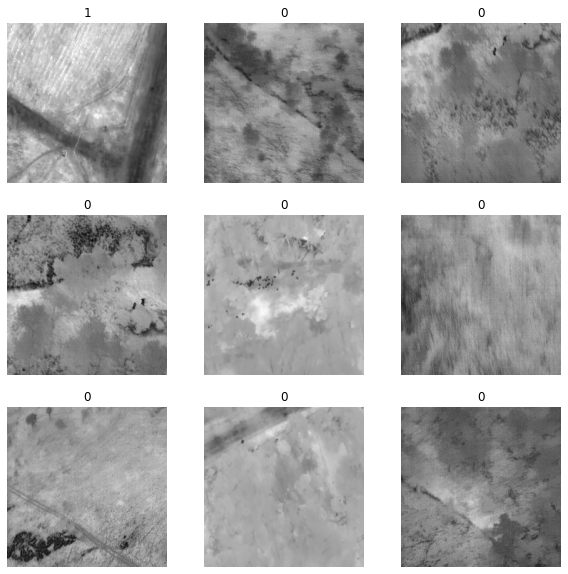

In [40]:
# visualizing the data 
# val 
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

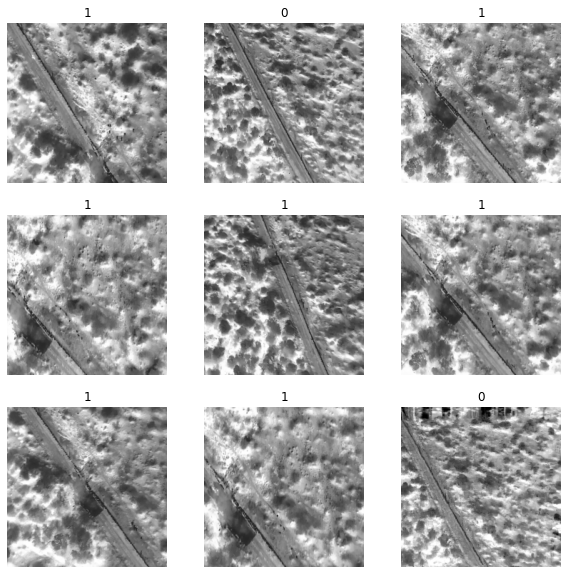

In [41]:
# visualizing the data 
# test 
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1): # images are eager tensors with 'float32' dtype and shape [64,256,256,1], labels are eager tensors with 'int32' dtype and shape (64,)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().squeeze().astype('uint8') 
        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

### Defining model architecture, optimizer settings, etc 

In [42]:
# function for defining model architecture 
def make_model(input_shape):
    inputs = Input(shape=input_shape)

    # EfficientNetB0
    model = EfficientNetB0(include_top=False, input_shape=input_shape, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = model(inputs)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    model = Model(inputs, outputs, name='EfficientNetB0')

    # compiling the model - setting loss function, metrics and optimizer , defining callbacks 
    opt  = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ['accuracy']
    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    return model

# instantiating the model
with strategy.scope():
  model = make_model(input_shape= image_size + (3,) )

model.summary()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### Training the model 

In [44]:
checkpoint = ModelCheckpoint('best_model_efficient_netB0.h5', 
                              monitor="val_accuracy", mode="max", 
                              save_weights_only=True, save_best_only=True, save_freq='epoch' , 
                              verbose=1 )
callbacks = [checkpoint]

num_epochs = 10
H = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks = callbacks)

Epoch 1/10
375/375 [==============================] - 62s 162ms/step - loss: 0.3638 - accuracy: 0.8443 - val_loss: 0.2831 - val_accuracy: 0.8938

Epoch 00001: val_accuracy improved from -inf to 0.89381, saving model to best_model_efficient_netB0.h5
Epoch 2/10
375/375 [==============================] - 61s 161ms/step - loss: 0.3399 - accuracy: 0.8553 - val_loss: 0.2576 - val_accuracy: 0.8993

Epoch 00002: val_accuracy improved from 0.89381 to 0.89932, saving model to best_model_efficient_netB0.h5
Epoch 3/10
375/375 [==============================] - 61s 160ms/step - loss: 0.3248 - accuracy: 0.8613 - val_loss: 0.2456 - val_accuracy: 0.9107

Epoch 00003: val_accuracy improved from 0.89932 to 0.91067, saving model to best_model_efficient_netB0.h5
Epoch 4/10
375/375 [==============================] - 61s 161ms/step - loss: 0.3258 - accuracy: 0.8596 - val_loss: 0.2426 - val_accuracy: 0.9063

Epoch 00004: val_accuracy did not improve from 0.91067
Epoch 5/10
375/375 [==========================

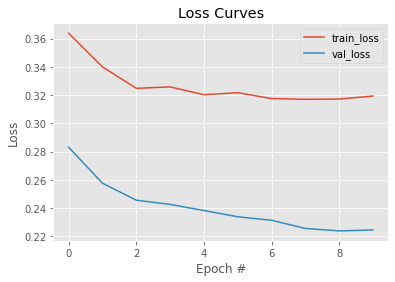

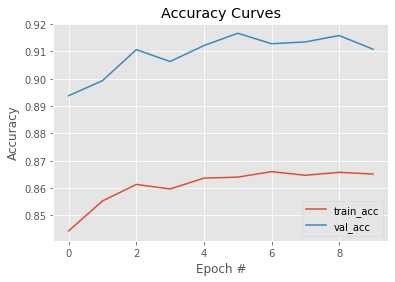

In [45]:
# plotting loss and accuracy curves 
plt.style.use('ggplot')
# loss plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
plt.title("Loss Curves")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
# accuracy plots
plt.figure()
plt.plot(np.arange(num_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(num_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
# evaluation on train set 
train_loss, train_accuracy = model.evaluate(train_ds)

# evaluation on val set 
val_loss, val_accuracy = model.evaluate(val_ds)

# evaluation on test set 
test_loss, test_accuracy = model.evaluate(test_ds)


45/45 [==============================] - 7s 131ms/step - loss: 1.5470 - accuracy: 0.3930


In [48]:
print("Efficient Net B0")
print('train accuracy: {:.3f}'.format(train_accuracy))
print('val accuracy: {:.3f}'.format(val_accuracy))
print('test accuracy: {:.3f} '.format(test_accuracy))

Efficient Net B0
train accuracy: 0.912
val accuracy: 0.911
test accuracy: 0.393 
